In [1]:
import json
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from collections import Counter
import math
from statistics import mean

import numpy as np
from numpy import dot
from numpy.linalg import norm

import scipy
from scipy.optimize import linear_sum_assignment

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anyaji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [4]:
from nltk.tokenize import word_tokenize as tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [5]:
f = open('../sparse+12.json')
data = json.load(f)

In [22]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
})

In [7]:
def clean(x):
    words = tokenize(x.lower())
    wl = [stemmer.stem(w) for w in words if w not in stop_words and (w.islower() or w.isalnum())]
    return wl

In [8]:
sampled = [
  "page2-34.svg",
  "page9-46.svg",
  "page3-85.svg",
  "page7-107.svg",
  "page8-159.svg",
  "page6-203.svg",
  "page2-112.svg",
  "page1-116.svg",
  "page1-69.svg",
  "page8-234.svg",
  "page8-21.svg",
  "page5-75.svg",
  "page1-0.svg",
  "page5-59.svg",
  "page3-121.svg",
  "page6-164.svg",
  "page4-128.svg",
  "page5-136.svg",
  "page6-99.svg",
  "page7-14.svg",
  "page5-128.svg",
  "page9-27.svg",
  "page7-105.svg",
  "page6-162.svg",
  "page9-13.svg",
  "page1-128.svg",
  "page5-186.svg",
  "page3-72.svg",
  "page4-157.svg",
  "page3-182.svg",
  "page7-197.svg",
  "page7-180.svg",
  "page6-143.svg",
  "page7-81.svg",
  "page3-136.svg",
  "page5-64.svg",
  "page7-218.svg",
  "page3-128.svg",
  "page7-26.svg",
  "page6-78.svg",
  "page4-24.svg",
  "page5-153.svg",
  "page7-248.svg",
  "page5-244.svg",
  "page4-93.svg",
  "page5-28.svg",
  "page8-235.svg",
  "page5-200.svg",
  "page2-131.svg",
  "page8-183.svg",
  "page1-119.svg",
  "page5-232.svg",
  "page1-129.svg",
  "page4-162.svg",
  "page3-41.svg",
  "page6-180.svg",
  "page6-149.svg",
  "page1-105.svg",
  "page4-10.svg",
  "page5-178.svg",
  "page2-137.svg",
  "page3-35.svg",
  "page-A.svg",
  "page-B.svg",
  "page-C.svg",
  "page-D.svg",
  "page-E.svg",
  "page-F.svg",
  "page-G.svg",
  "page-H.svg",
  "page-I.svg",
  "page-J.svg",
  "page-K.svg",
  "page-L.svg",
]

# Segmentation Agreement

In [9]:
# https://cstheory.stackexchange.com/questions/6569/edit-distance-between-two-partitions/6582#6582
'''
d: {1:str, 2:str, ..., 7:str}
returns s: e.g. [[1,2,5],[4],[3,6,7]]
'''
def make_sets(d):
    s=[]
    rev=defaultdict(list)
    for k,v in d.items():
        rev[v].append(k)
    for ann, ind_set in rev.items():
        s.append(ind_set)
    return s

def weight(s1,s2):
    return len(set(s1)&set(s2)) #weight is the # of pieces matching

'''
l1,l2: e.g. [[1,2,5],[4],[3,6,7]]
returns: len(l1)*len(l2) cost matrix matching elm from l1 to l2
'''
def cost_matrix(l1,l2):
    mat = np.zeros((len(l1),len(l2)))
    for i in range(len(l1)):
        for j in range(len(l2)):
            mat[i][j] = weight(l1[i],l2[j])
    return mat

'''
d1,d2: piece-annotation dictionaries
returns: number, higher value/cost == higher agreement (MAX number of pieces that do not change)
'''
def seg_agreement(d1,d2):
    cost = cost_matrix(make_sets(d1),make_sets(d2))
    row_ind, col_ind = linear_sum_assignment(cost, True) # maximum weight matching
    return cost[row_ind, col_ind].sum()
# print(seg_agreement({1:'body',2:'body',3:'body',4:'body',5:'face',6:'side fin',7:'tail fin of whale'},{1:'road',2:'crosswalk',3:'crosswalk',4:'crosswalk',5:'grass',6:'grass',7:'road'}))

In [10]:
file_to_segagr = defaultdict(float)
for file, anns in data['annotations'].items():
    piece_anns = [detail['piece-annotation'] for detail in anns.values()]
    mean_agr=0
    l=len(piece_anns)
    for i in range(l-1):
        for j in range(i+1,l):
            mean_agr += seg_agreement(piece_anns[i],piece_anns[j])
    mean_agr /= l*(l-1)/2
    file_to_segagr[file] = mean_agr  

# Naming Divergence

In [11]:
def naming_div(anns, is_whole_anns):
    word_to_count = defaultdict(int)
    cleaned_ann_list = []
    original_ann = []

    for user, ann in anns.items():
        if is_whole_anns:
            cleaned_ann = clean(ann['whole-annotation']['wholeAnnotation'])
            cleaned_ann_list.append(cleaned_ann)
            original_ann.append(ann['whole-annotation']['wholeAnnotation'])
        else:
            cleaned_ann = []
            parts_set = set(ann['piece-annotation'].values()) # parts, excluding duplicates
            for word in parts_set:
                wl = clean(word)
                cleaned_ann+= wl
            cleaned_ann_list.append(cleaned_ann)
            original_ann.append(list(set(ann['piece-annotation'].values())))

    nd = 0
    num_ann = len(cleaned_ann_list)
    # each annotation
    for i in range(len(cleaned_ann_list)):
        frq = 0
        # each word in one annotation
        wl = cleaned_ann_list[i]
        for w in wl:
            appeared=0
            for j in range(len(cleaned_ann_list)):
                if j!=i:
                    wll = cleaned_ann_list[j]
                    if w in wll:
                        appeared+=1
            frq += 1 - appeared / (num_ann-1) #proportion of the word appearing in other annotations
        if len(wl) != 0:
            nd += frq/len(wl) # nd += mean frq (1-p) of each annotation
    return nd/num_ann #,original_ann

In [12]:
file_to_nd_whole = {} # {(divergence, unique set), ...}
for file, anns in data['annotations'].items():
    file_to_nd_whole[file] = naming_div(anns, True)

In [13]:
file_to_nd_part = {} # {(divergence, unique set), ...}
for file, anns in data['annotations'].items():
    file_to_nd_part[file] = naming_div(anns, False)

In [14]:
def print_stats(filename):
    print(file_to_nd_whole[filename], file_to_nd_part[filename], file_to_segagr[filename])

In [15]:
print_stats('page1-69')

0.8592592592592592 0.7119047619047618 7.0


# Correlations

In [16]:
from scipy import stats
def format_correlation(a,b):
    r,p = stats.spearmanr(a,b)
    print(r,p)
    
    r = str(float("{:.3f}".format(r))).replace('0', '', 1)
    
    if p<0.001:
        pp='p<.001$'
    
    return r'$r(1014)='+r+', '+pp

0.5310886209655183 5.137522430103275e-75
-0.1652337237009724 1.1788233009229847e-07
-0.21568070305458162 3.698641836524767e-12


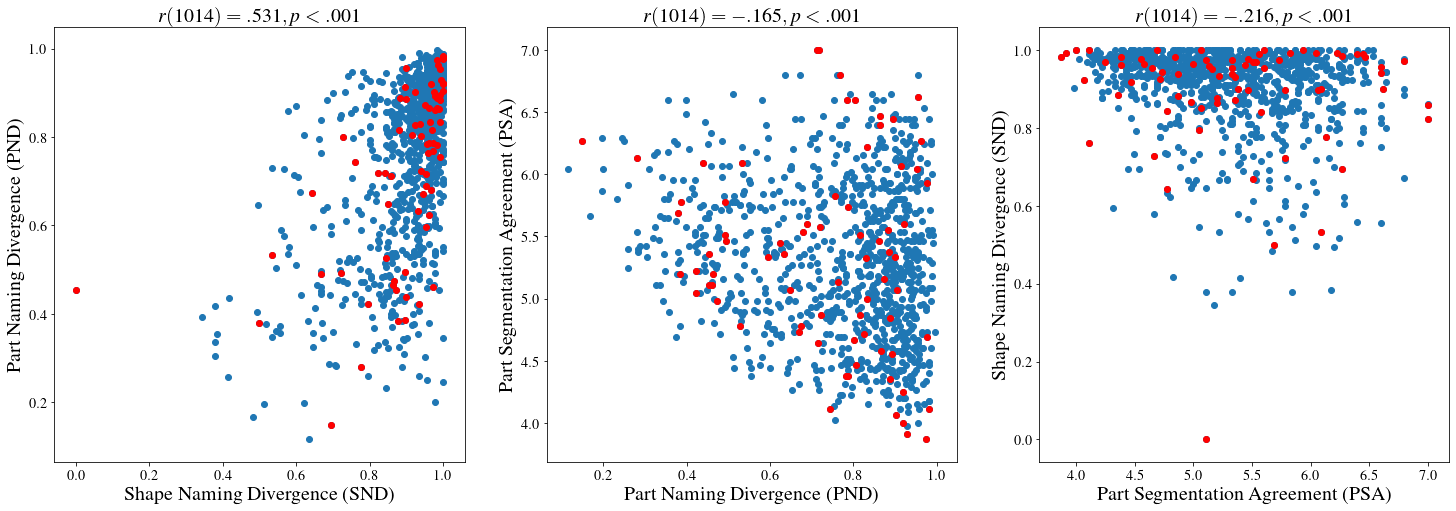

In [26]:
from scipy import stats

seg=[]
whole_nd=[]
part_nd=[]

for f, agr in file_to_segagr.items():
    seg.append(agr)
    whole_nd.append(file_to_nd_whole[f])
    part_nd.append(file_to_nd_part[f])
    
    
d_seg=[]
d_whole_nd=[]
d_part_nd=[]

for f, agr in file_to_segagr.items():
    if f+'.svg' in sampled:
        d_seg.append(agr)
        d_whole_nd.append(file_to_nd_whole[f])
        d_part_nd.append(file_to_nd_part[f])
    
    
datapoints = [whole_nd, part_nd, seg]
d_datapoints = [d_whole_nd, d_part_nd, d_seg]
idx=1
plt.subplots(1,3,figsize=(25,8))

plt.subplot(1, 3, 1)
plt.scatter(datapoints[0],datapoints[1])
plt.scatter(d_datapoints[0],d_datapoints[1], color="red")
plt.xlabel("Shape Naming Divergence (SND)", fontsize=20)
plt.ylabel("Part Naming Divergence (PND)", fontsize=20)
plt.title(format_correlation(datapoints[0],datapoints[1]), fontsize=20)


plt.subplot(1, 3, 2)
plt.scatter(datapoints[1],datapoints[2])
plt.scatter(d_datapoints[1],d_datapoints[2], color="red")
plt.xlabel("Part Naming Divergence (PND)", fontsize=20)
plt.ylabel("Part Segmentation Agreement (PSA)", fontsize=20)
plt.title(format_correlation(datapoints[1],datapoints[2]), fontsize=20)

plt.subplot(1, 3, 3)
plt.scatter(datapoints[2],datapoints[0])
plt.scatter(d_datapoints[2],d_datapoints[0], color="red")
plt.xlabel("Part Segmentation Agreement (PSA)", fontsize=20)
plt.ylabel("Shape Naming Divergence (SND)", fontsize=20)
plt.title(format_correlation(datapoints[2],datapoints[0]), fontsize=20)

plt.show()

0.5310886209655183 5.137522430103275e-75


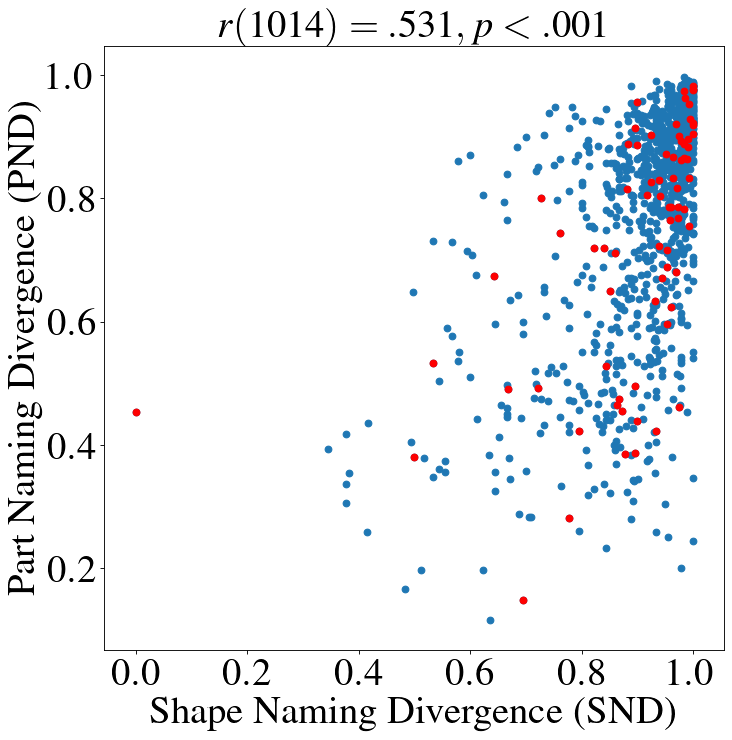

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=80)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.scatter(datapoints[0],datapoints[1])
plt.scatter(d_datapoints[0],d_datapoints[1], color="red")
plt.xlabel("Shape Naming Divergence (SND)", fontsize=35)
plt.ylabel("Part Naming Divergence (PND)", fontsize=35)
plt.title(format_correlation(datapoints[0],datapoints[1]), fontsize=35)

# plt.show()
plt.savefig('PND-SND.pdf')

-0.1652337237009724 1.1788233009229847e-07


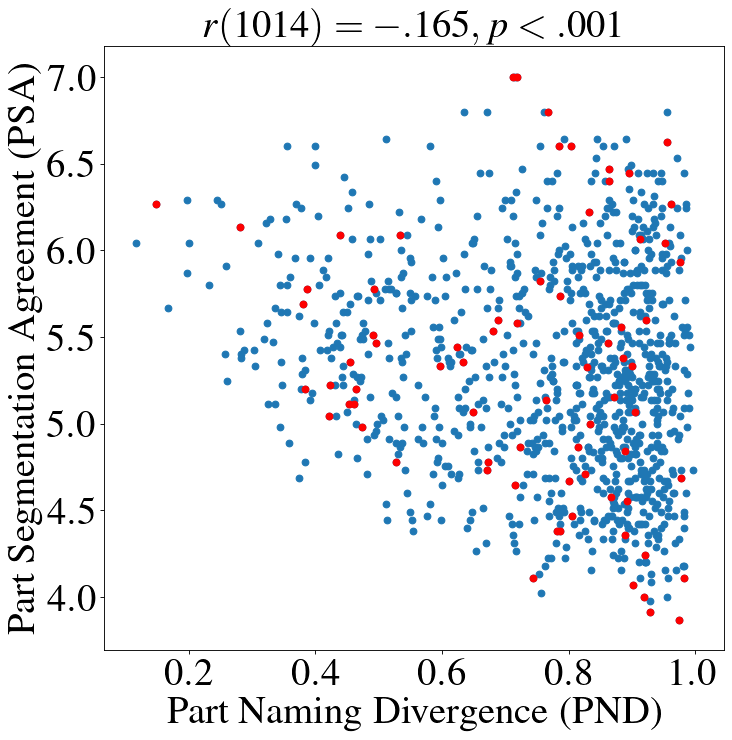

In [28]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=80)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.scatter(datapoints[1],datapoints[2])
plt.scatter(d_datapoints[1],d_datapoints[2], color="red")
plt.xlabel("Part Naming Divergence (PND)", fontsize=35)
plt.ylabel("Part Segmentation Agreement (PSA)", fontsize=35)
plt.title(format_correlation(datapoints[1],datapoints[2]), fontsize=35)

# plt.show()
plt.savefig('PND-PSA.pdf')

-0.21568070305458162 3.698641836524767e-12


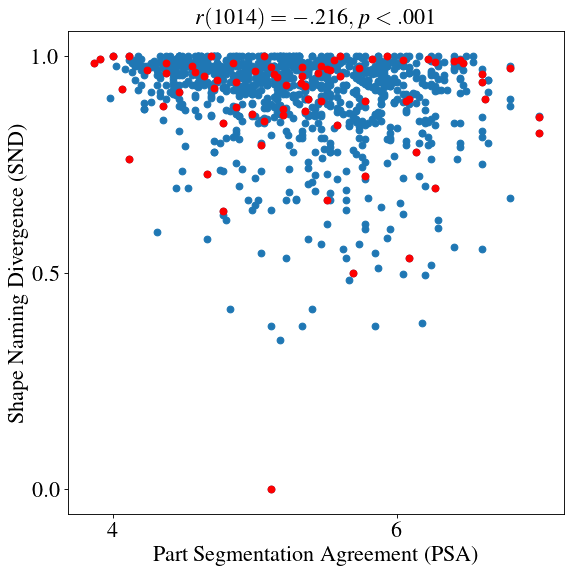

In [20]:
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.scatter(datapoints[2],datapoints[0])
plt.scatter(d_datapoints[2],d_datapoints[0], color="red")
plt.xlabel("Part Segmentation Agreement (PSA)", fontsize=20)
plt.ylabel("Shape Naming Divergence (SND)", fontsize=20)
plt.title(format_correlation(datapoints[2],datapoints[0]), fontsize=20)

# plt.show()
plt.savefig('PSA-SND.pdf')